In [184]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 

from tslearn.clustering import TimeSeriesKMeans, KernelKMeans
from tslearn.metrics import dtw

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.datasets import CachedDatasets

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sbn

import networkx as nx

from sklearn.svm import SVC
from sklearn.feature_selection import RFE

import os

# HER2 project 

> Goal: Match `HER2` mutations to specific targeted therapies. 
    
Experimental Summary: 
For a given cell line, a specific `HER2` mutation is induced and the functional response to a given drug is measured by `live cell reporter imaging`. This let's us characterize the time series pathway response when the mutant cell line is exposed to the drug. Each experiment also has two controls: 

> WT SKB cells: These cells are `sensitive` to both `neratinib` and `Trastuzumab` 

> T798I cells: These cells are `resistant` to `neratinib` and has an unknown response to `Trastuzumab`


T798I is resistant to neratinib, and wt is sensitive to both
[3:42 PM] Samuel Tsang
    We don't know about T798I sensitivity to trastuzumab
based on the reporter data, it could be resistant as well

The goal of this analysis is to explore how to assign mutant `HER2` cell lines resistance/sensitivity calls. 

[tslearn k-means tutorial](https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py) 

# shaplets 


# Doulbe check: normalized data?

why do we still see spike 

# Load Data 

Stored in `../data/HER2/`

In [105]:
load = 'normalized' # or 'raw'

_datas = []
for dataset in os.listdir('../data/HER2'): 
    cl_path = '../data/HER2/' + dataset + '/' + load + '/clover_all_cell.csv'
    ms_path = '../data/HER2/' + dataset + '/' + load + '/mscarlet_all_cell.csv'
    _clover = pd.read_csv(cl_path)
    _mscarl = pd.read_csv(ms_path)
    _data = _clover.merge(_mscarl, on=['track_index', 'cell__treatment'], how='inner')
    _data = _data.assign(dataset=dataset)
    _datas.append(_data)
    
data = pd.concat(_datas, axis=0)

series_sel = [x.split('_')[0] for x in clover.columns[1:-3]]
clover_sel = [f'{x}_x' for x in series_sel]
mscarl_sel = [f'{x}_y' for x in series_sel]

data = data.assign(drug = [x.split('_', maxsplit=5)[-1] for x in data.cell__treatment])
data = data.assign(cell_line = [x.split('_', maxsplit=5)[0] for x in data.cell__treatment])
data = data.assign(mutant = [x.split('_', maxsplit=5)[-2] for x in data.cell__treatment])

data.head()

,track_index,0.0_x,0.2_x,0.5_x,0.8_x,1.0_x,1.2_x,1.5_x,1.8_x,2.0_x,...,56.8_y,57.0_y,57.2_y,57.5_y,57.8_y,58.0_y,58.2_y,site_y,median_y,dataset
0,69_1000049620_skbr3_erk_akt__WT_untreated,0.784316,0.786841,0.603200,0.541081,0.458533,0.431992,0.712106,0.699950,0.730170,...,0.180696,0.072726,0.110119,0.242807,0.127572,0.132009,0.047259,69,0.299107,H210122_SKBR3
1,2_1000028311_skbr3_erk_akt__WT_untreated,0.602541,0.605066,0.421425,0.605618,0.691947,0.672889,0.614016,0.661317,0.682537,...,0.462619,0.497468,0.522712,0.557662,0.562536,0.564215,0.564624,2,0.693558,H210122_SKBR3
2,69_1000046124_skbr3_erk_akt__WT_untreated,0.777447,0.753066,0.476562,0.595350,0.605771,0.767272,0.737938,0.733756,0.776656,...,0.434130,0.453317,0.459603,0.522485,0.451602,0.484998,0.550944,69,0.509604,H210122_SKBR3
3,0_1000000658_skbr3_erk_akt__WT_untreated,0.831403,0.652266,0.454141,0.696562,0.757371,0.882979,0.805273,0.936487,0.915338,...,0.749348,0.778288,0.716950,0.779451,0.878771,0.866162,0.826636,0,0.607951,H210122_SKBR3
4,75_1000100136_skbr3_erk_akt__WT_untreated,0.165367,0.141473,0.447377,0.482309,0.478944,0.658566,0.682605,0.727898,0.744381,...,0.431749,0.500994,0.537379,0.562468,0.551105,0.634450,0.626864,75,0.668938,H210122_SKBR3


In [106]:
series_sel = [x.split('_')[0] for x in clover.columns[1:-3]]
clover_sel = [f'{x}_x' for x in series_sel]
mscarl_sel = [f'{x}_y' for x in series_sel]

In [107]:
data = data.assign(drug = [x.split('_', maxsplit=5)[-1] for x in data.cell__treatment])
data = data.assign(cell_line = [x.split('_', maxsplit=5)[0] for x in data.cell__treatment])
data = data.assign(mutant = [x.split('_', maxsplit=5)[-2] for x in data.cell__treatment])
data.head()

,track_index,0.0_x,0.2_x,0.5_x,0.8_x,1.0_x,1.2_x,1.5_x,1.8_x,2.0_x,...,57.5_y,57.8_y,58.0_y,58.2_y,site_y,median_y,dataset,drug,cell_line,mutant
0,69_1000049620_skbr3_erk_akt__WT_untreated,0.784316,0.786841,0.603200,0.541081,0.458533,0.431992,0.712106,0.699950,0.730170,...,0.242807,0.127572,0.132009,0.047259,69,0.299107,H210122_SKBR3,untreated,skbr3,WT
1,2_1000028311_skbr3_erk_akt__WT_untreated,0.602541,0.605066,0.421425,0.605618,0.691947,0.672889,0.614016,0.661317,0.682537,...,0.557662,0.562536,0.564215,0.564624,2,0.693558,H210122_SKBR3,untreated,skbr3,WT
2,69_1000046124_skbr3_erk_akt__WT_untreated,0.777447,0.753066,0.476562,0.595350,0.605771,0.767272,0.737938,0.733756,0.776656,...,0.522485,0.451602,0.484998,0.550944,69,0.509604,H210122_SKBR3,untreated,skbr3,WT
3,0_1000000658_skbr3_erk_akt__WT_untreated,0.831403,0.652266,0.454141,0.696562,0.757371,0.882979,0.805273,0.936487,0.915338,...,0.779451,0.878771,0.866162,0.826636,0,0.607951,H210122_SKBR3,untreated,skbr3,WT
4,75_1000100136_skbr3_erk_akt__WT_untreated,0.165367,0.141473,0.447377,0.482309,0.478944,0.658566,0.682605,0.727898,0.744381,...,0.562468,0.551105,0.634450,0.626864,75,0.668938,H210122_SKBR3,untreated,skbr3,WT


# Brief EDA 

In [108]:
data.shape

(14220, 478)

In [109]:
data.cell__treatment.unique()

array(['skbr3_erk_akt__WT_untreated', 'skbr3_erk_akt__WT_10nm_neratinib',
       'skbr3_erk_akt__WT_10ug_ml_trastuzumab',
       'skbr3_erk_akt__T798I_untreated',
       'skbr3_erk_akt__T798I_10nm_neratinib',
       'skbr3_erk_akt__T798I_10ug_ml_trastuzumab',
       'skbr3_erk_akt__Nd611_untreated',
       'skbr3_erk_akt__Nd611_10nm_neratinib',
       'skbr3_erk_akt__Nd611_10ug_ml_trastuzumab',
       'skbr3_erk_akt__Nd648_untreated',
       'skbr3_erk_akt__Nd648_10nm_neratinib',
       'skbr3_erk_akt__Nd648_10ug_ml_trastuzumab',
       'skbr3_erk_akt__S310Y_untreated',
       'skbr3_erk_akt__S310Y_10nm_neratinib',
       'skbr3_erk_akt__S310Y_10ug_ml_trastuzumab',
       'skbr3_erk_akt__T306M_untreated',
       'skbr3_erk_akt__T306M_10nm_neratinib',
       'skbr3_erk_akt__T306M_10ug_ml_trastuzumab',
       'skbr3_erk_akt__L313V_untreated',
       'skbr3_erk_akt__L313V_10nm_neratinib',
       'skbr3_erk_akt__L313V_10ug_ml_trastuzumab',
       'skbr3_erk_akt__T733I_untreated',
       's

In [110]:
data.mutant.unique()

array(['WT', 'T798I', 'Nd611', 'Nd648', 'S310Y', 'T306M', 'L313V',
       'T733I', 'L755T759DEL', 'I767M', 'ND611', 'ND648', 'A355QFS76',
       'D639E', 'Y835F', 'V842I', 'R678Q', 'V424I', 'D769Y', 'E717K',
       'E744D', 'G621AFS31', 'I435L', 'I886M', 'L43V', 'P416T', 'P702L',
       'R203P', 'R340G', 'R456C', 'R47C', 'S609C', 'T479M', 'W906C',
       'Y64F', 'D277H', 'D638H', 'D873G', 'G1055C', 'G778S779insLPS',
       'H470Q', 'H878Y', 'L662V', 'M833I'], dtype=object)

In [111]:
data.drug.unique()

array(['untreated', '10nm_neratinib', '10ug_ml_trastuzumab'], dtype=object)

In [112]:
data.cell_line.unique()

array(['skbr3'], dtype=object)

In [113]:
ntreatments = len(data.cell__treatment.unique())
print('# of treatment groups:', ntreatments)

# of treatment groups: 132


In [114]:
treatment_cnts = data.groupby('cell__treatment')['track_index'].count()
treatment_cnts

cell__treatment
skbr3_erk_akt__A355QFS76_10nm_neratinib          51
skbr3_erk_akt__A355QFS76_10ug_ml_trastuzumab     51
skbr3_erk_akt__A355QFS76_untreated               47
skbr3_erk_akt__D277H_10nm_neratinib             145
skbr3_erk_akt__D277H_10ug_ml_trastuzumab        125
                                               ... 
skbr3_erk_akt__Y64F_10ug_ml_trastuzumab         109
skbr3_erk_akt__Y64F_untreated                    76
skbr3_erk_akt__Y835F_10nm_neratinib              63
skbr3_erk_akt__Y835F_10ug_ml_trastuzumab         71
skbr3_erk_akt__Y835F_untreated                   53
Name: track_index, Length: 132, dtype: int64

In [120]:
data[['cell__treatment','dataset']].drop_duplicates().groupby('cell__treatment').count().sort_values('dataset')

,dataset
cell__treatment,
skbr3_erk_akt__A355QFS76_10nm_neratinib,1
skbr3_erk_akt__R678Q_10nm_neratinib,1
skbr3_erk_akt__R47C_untreated,1
skbr3_erk_akt__R47C_10ug_ml_trastuzumab,1
skbr3_erk_akt__R47C_10nm_neratinib,1
...,...
skbr3_erk_akt__WT_10nm_neratinib,7
skbr3_erk_akt__T798I_untreated,7
skbr3_erk_akt__T798I_10nm_neratinib,7


# K-means clustering

In [253]:
#X_train = data[clover_sel]
X_train = np.stack([data[clover_sel], data[mscarl_sel]], axis=2)
print(X_train.shape)

# should we remove the first n number of points - avoid that initial spike... 
X_train = X_train[:, :, :]

# does zscoring the time series make sense? I don't think so. 
#X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

# Make time series shorter
X_train = TimeSeriesResampler(sz=100).fit_transform(X_train)
sz = X_train.shape[1]
print(X_train.shape)
nclus = 25

(14220, 234, 2)
(14220, 100, 2)


In [254]:
#?TimeSeriesKMeans

In [255]:
# Euclidean k-means
# metric can be: euclidean, dtw, softdtw

# Euclidean 
km = TimeSeriesKMeans(n_clusters=nclus, verbose=True, random_state=0, metric='euclidean', n_jobs=8)
y_pred = km.fit_predict(X_train)

# DTW 
#km = TimeSeriesKMeans(n_clusters=nclus, verbose=False, random_state=0, metric='dtw', n_jobs=8)
#y_pred = km.fit_predict(X_train)

# Kernel
#gak_km = KernelKMeans(n_clusters=nclus,
##                     kernel_params={"sigma": "auto"},
 #                     n_init=20,
 #                     verbose=False,
 #                     random_state=0,
 #                     n_jobs=8)

#y_pred = gak_km.fit_predict(X_train)

5.098 --> 3.965 --> 3.853 --> 3.809 --> 3.786 --> 3.772 --> 3.763 --> 3.756 --> 3.751 --> 3.747 --> 3.743 --> 3.740 --> 3.738 --> 3.736 --> 3.735 --> 3.734 --> 3.733 --> 3.733 --> 3.732 --> 3.732 --> 3.731 --> 3.731 --> 3.731 --> 3.730 --> 3.730 --> 3.730 --> 3.729 --> 3.729 --> 3.729 --> 3.729 --> 3.729 --> 3.729 --> 3.728 --> 3.728 --> 3.728 --> 3.728 --> 3.728 --> 3.728 --> 3.728 --> 3.727 --> 3.727 --> 3.727 --> 3.727 --> 3.727 --> 3.727 --> 3.727 --> 3.726 --> 3.726 --> 3.726 --> 3.726 --> 


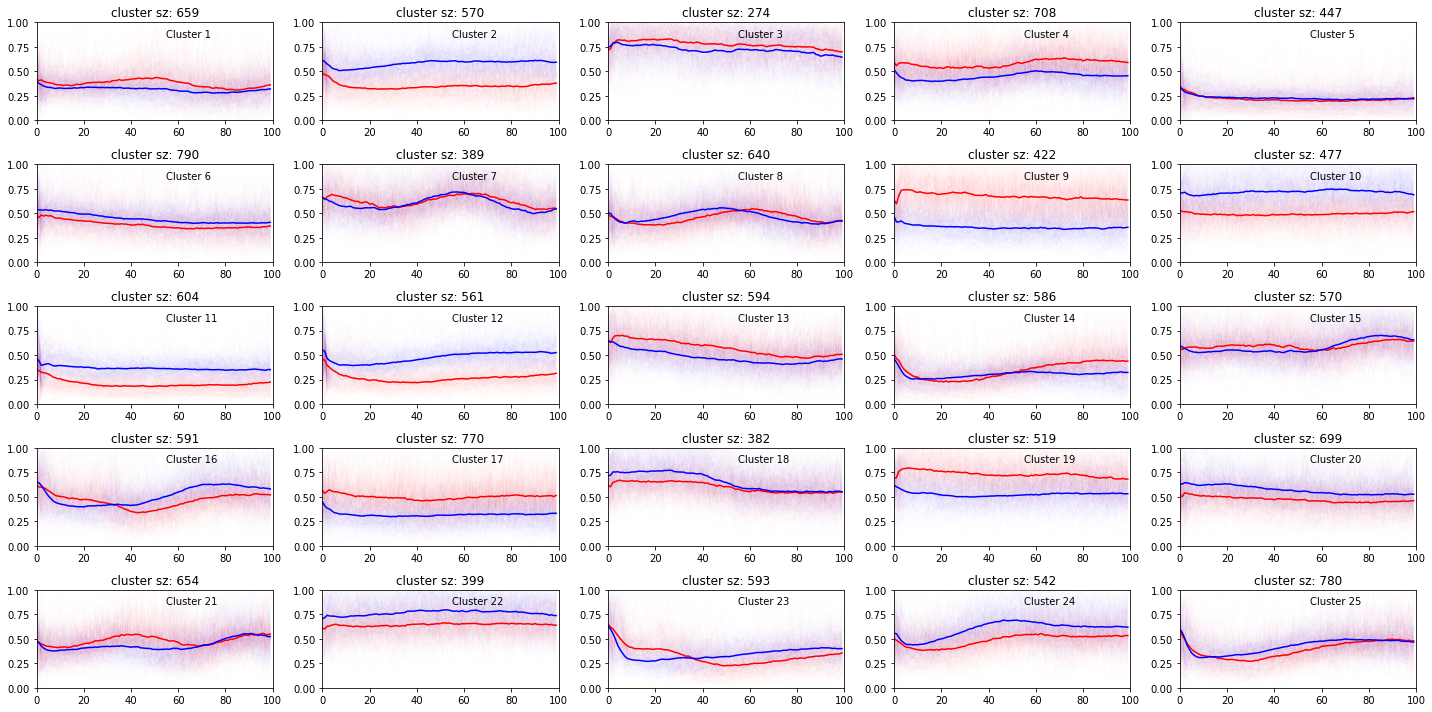

In [256]:
plt.figure(figsize=(20,10))
for yi in range(nclus):
    plt.subplot(5, 5, yi + 1)
    for xx in X_train[y_pred == yi][0:250]:
        plt.plot(xx[:,0], "r-", alpha=.05)
        plt.plot(xx[:,1], "b-", alpha=.05)
        
    plt.title(f'cluster sz: {len(X_train[y_pred == yi])}')
    plt.plot(km.cluster_centers_[yi][:,0], "r-", label='clover')
    plt.plot(km.cluster_centers_[yi][:,1], "b-", label='mscarlet')
    
    plt.xlim(0, sz)
    plt.ylim(0, 1)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [257]:
lb = LabelEncoder()
y_trt = lb.fit_transform([f'{x}--{y}' for x,y in zip(data.cell__treatment.values, data.dataset.values)])

In [258]:
cm_cnts = {c:np.zeros(nclus) for c in lb.classes_} 

In [259]:
len(y_trt)

14220

In [260]:
len(y_pred)

14220

In [261]:
for i, clus, grp in zip(range(len(y_pred)), y_pred, y_trt) :
    cm_cnts[lb.classes_[grp]][clus] += 1

In [262]:
# should be 51 
cm_cnts['skbr3_erk_akt__A355QFS76_10nm_neratinib--H210205_Set2'].sum()

51.0

In [263]:
cm_prob = {k:v/np.sum(v) for k,v in cm_cnts.items()}
sum(cm_prob[lb.classes_[0]])

1.0000000000000002

In [264]:
labels = [k for k,v in cm_prob.items()]
cm = np.stack([v for k,v in cm_prob.items()], axis=0)
cm.shape

(186, 25)

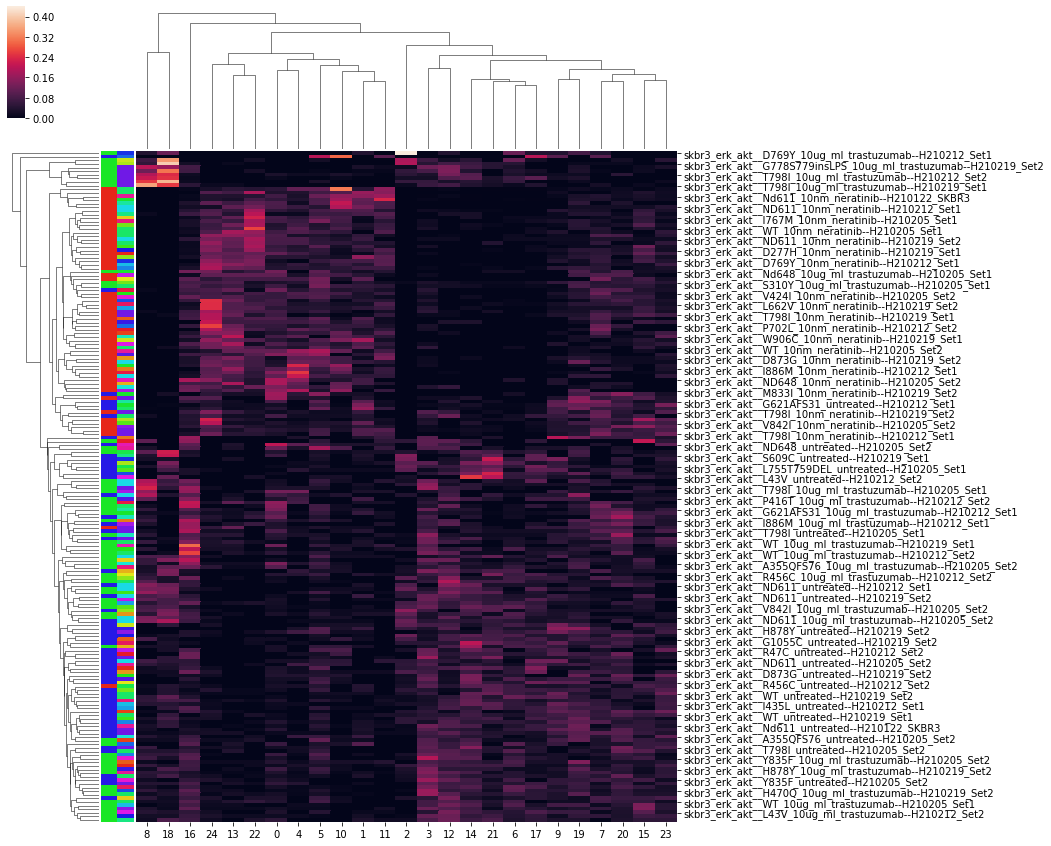

In [265]:
#drug = dict(zip(data.drug.unique(), "rbg"))
#row_colors = data.drug.map(drug)
#g = sbn.clustermap(cm, row_colors=row_colors)
# [x.split('--')[0].split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[4] for x in lb.classes_]

drug = [x.split('--')[0].split('_')[-1] for x in labels]
lut = dict(zip(set(drug), sbn.hls_palette(len(set(drug)), l=0.5, s=0.8)))
row_colors = pd.DataFrame(drug)[0].map(lut)

#Create additional row_colors here
cell_line = [x.split('_')[4] for x in labels]
lut2 = dict(zip(set(cell_line), sbn.hls_palette(len(set(cell_line)), l=0.5, s=0.8)))
row_colors2 = pd.DataFrame(cell_line)[0].map(lut2)

df = pd.DataFrame(index=labels, data=cm)
sbn.clustermap(df, figsize=(12,15), row_colors=[row_colors, row_colors2]) 

#plt.ylabel('treatment')
#plt.yticks(ticks=plt.yticks()[0], labels=[str(x) for x in labels])
#plt.xlabel('cluster label')
plt.show()

# Let's look at control replicates first

In [236]:
cm_repl = {k:v for k,v in cm_prob.items() if (k.split('--')[0].split('_', maxsplit=5)[-2] in ['WT','T798I'])}

In [238]:
len(cm_repl)

42

# Feature selection 

Not all of these clusters may be relevant to drug sensitivity/resistance. 

As a very naive approach, we'll train a svc classifier to predict `untreated` from `treated`. Then we'll choose which clusters to use in later steps by the highest feature weights (using a linear kernel). 

In [207]:
# if # clusters > # classes
cm = cm[0:len(lb.classes_), :]
cm.shape

(186, 12)

In [210]:
y = 1.*np.array(['untreated' in x for x in lb.classes_])

X = cm 
y = y.astype(float)

svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_
ranking

array([ 3,  5,  2,  4,  1,  6, 10,  9, 11,  8,  7, 12])

In [211]:
n_clusters_to_use = nclus
cm = cm[:, ranking <= n_clusters_to_use]
cm.shape

(186, 12)

# dimensionality reduction 

In [266]:
pca = PCA(n_components=2)
PCs = pca.fit_transform(cm)
print('explained variance ratio:', pca.explained_variance_ratio_)
print('PC shape:', PCs.shape)
res = pd.DataFrame({'pc1': PCs[:,0], 'pc2':PCs[:,1], 'treatment':[x.split('--')[0].split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[4] for x in lb.classes_]})
res.head()

explained variance ratio: [0.3411825  0.12435429]
PC shape: (186, 2)


,pc1,pc2,treatment,cell_line
0,-0.144412,0.012771,neratinib,A355QFS76
1,0.011993,-0.060846,trastuzumab,A355QFS76
2,0.035948,-0.057357,untreated,A355QFS76
3,-0.181693,0.045081,neratinib,D277H
4,0.079232,-0.061031,trastuzumab,D277H


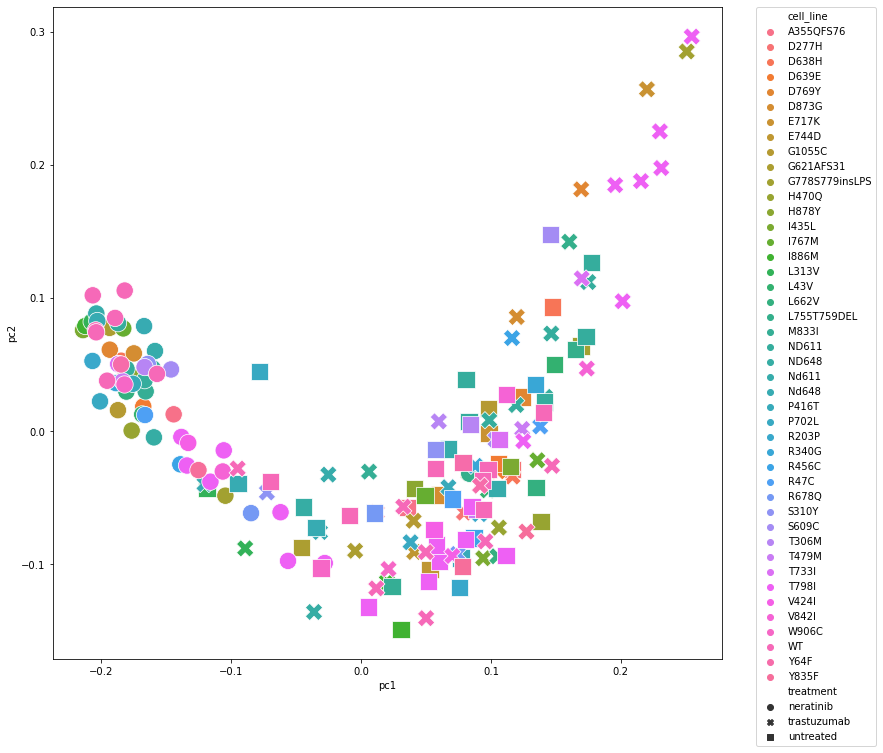

In [267]:
plt.figure(figsize=(12,12))
sbn.scatterplot(x='pc1', y='pc2', data=res, hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

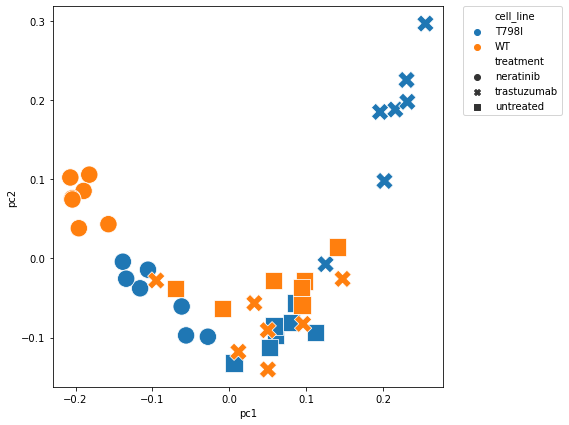

In [268]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='pc1', y='pc2', data=res[lambda x: (x.cell_line.isin(['WT', 'T798I']))], hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# PCA for just neratinib and untreated 

In [278]:
cm_ner = {k:v for k,v in cm_prob.items() if (k.split('--')[0].split('_', maxsplit=5)[-1] in ['untreated','10nm_neratinib'])}
cm_ner_X = np.stack([v for k,v in cm_ner.items()], axis=0)

pca = PCA(n_components=2)
PCs = pca.fit_transform(cm_ner_X)
print('explained variance ratio:', pca.explained_variance_ratio_)
print('PC shape:', PCs.shape)
res_ner = pd.DataFrame({'pc1': PCs[:,0], 'pc2':PCs[:,1], 'treatment':[x.split('--')[0].split('_')[-1] for x in cm_ner.keys()], 'cell_line':[x.split('_')[4] for x in cm_ner.keys()]})
res_ner.head()

explained variance ratio: [0.38325425 0.10355933]
PC shape: (124, 2)


,pc1,pc2,treatment,cell_line
0,-0.117539,0.034352,neratinib,A355QFS76
1,0.091679,-0.008280,untreated,A355QFS76
2,-0.141935,-0.040281,neratinib,D277H
3,0.173025,-0.006678,untreated,D277H
4,-0.147445,-0.031147,neratinib,D638H


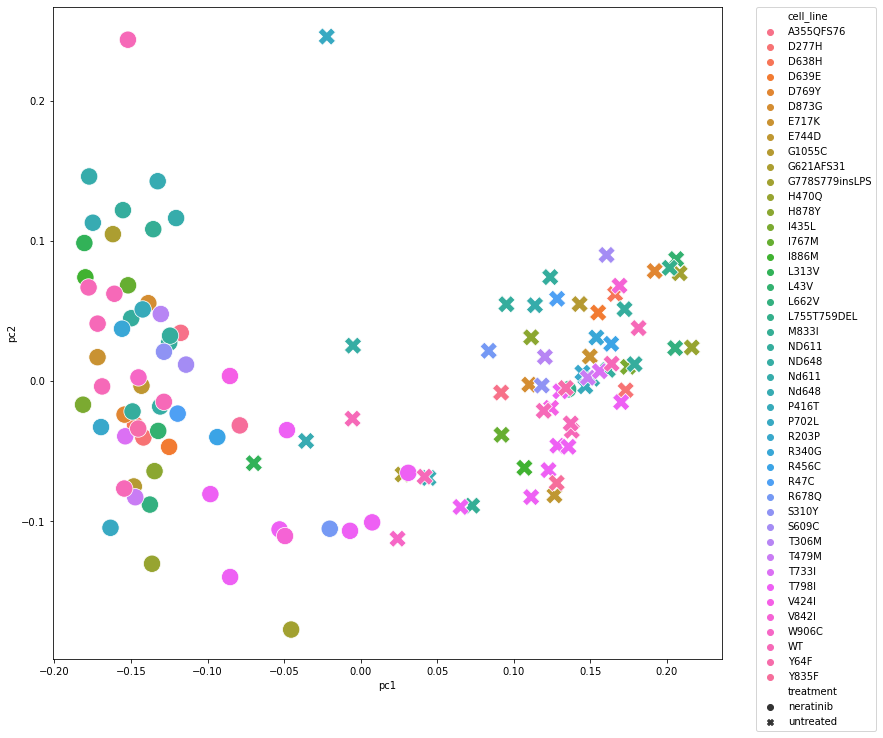

In [279]:
plt.figure(figsize=(12,12))
sbn.scatterplot(x='pc1', y='pc2', data=res_ner, hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

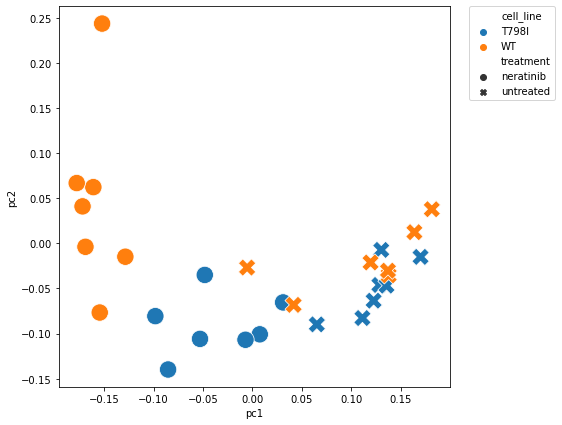

In [280]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='pc1', y='pc2', data=res_ner[lambda x: (x.cell_line.isin(['WT', 'T798I']))], hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# PCA for just trastuzumab and untreated 

In [288]:
cm_tra = {k:v for k,v in cm_prob.items() if (k.split('--')[0].split('_', maxsplit=5)[-1] in ['untreated','10ug_ml_trastuzumab'])}
cm_tra_X = np.stack([v for k,v in cm_tra.items()], axis=0)

pca = PCA(n_components=2)
PCs = pca.fit_transform(cm_tra_X)
print('explained variance ratio:', pca.explained_variance_ratio_)
print('PC shape:', PCs.shape)
res_tra = pd.DataFrame({'pc1': PCs[:,0], 'pc2':PCs[:,1], 'treatment':[x.split('--')[0].split('_')[-1] for x in cm_tra.keys()], 'cell_line':[x.split('_')[4] for x in cm_tra.keys()]})
res_tra.head()

explained variance ratio: [0.28098812 0.15373305]
PC shape: (124, 2)


,pc1,pc2,treatment,cell_line
0,-0.082182,0.098579,trastuzumab,A355QFS76
1,-0.063605,-0.016542,untreated,A355QFS76
2,-0.030343,-0.007770,trastuzumab,D277H
3,0.015564,-0.096625,untreated,D277H
4,0.008175,0.021189,trastuzumab,D638H


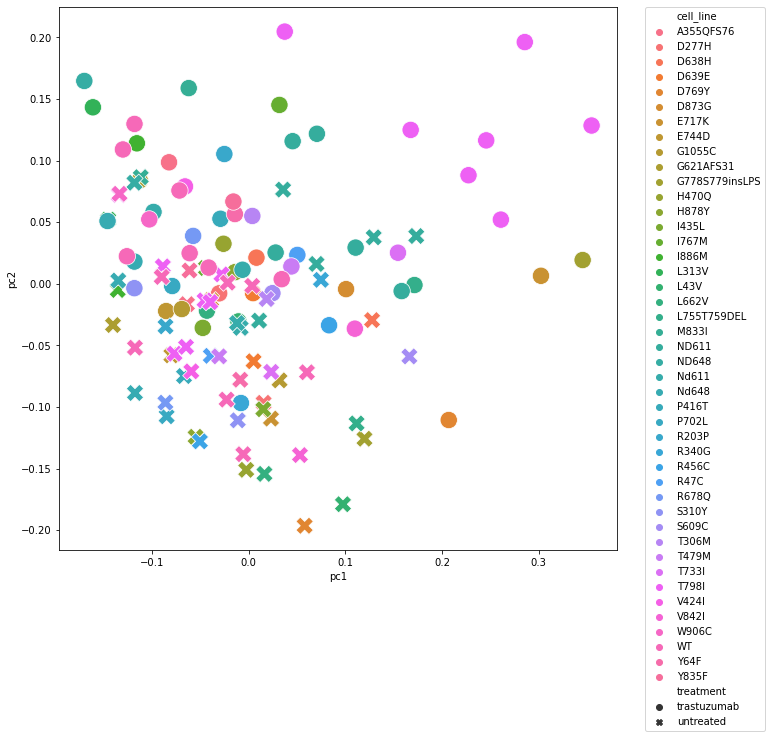

In [290]:
plt.figure(figsize=(10,10))
sbn.scatterplot(x='pc1', y='pc2', data=res_tra, hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

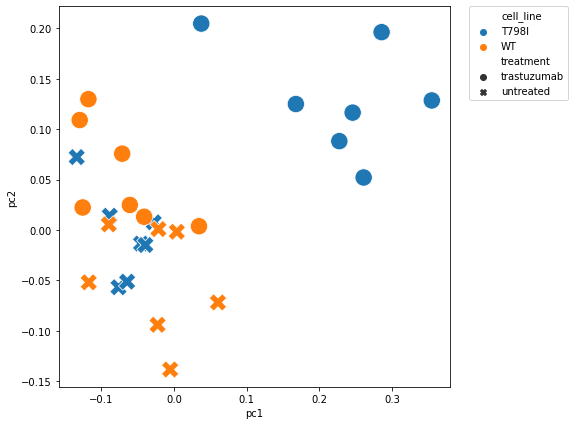

In [291]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='pc1', y='pc2', data=res_tra[lambda x: (x.cell_line.isin(['WT', 'T798I']))], hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# TSNE for all

In [251]:
X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(cm)

res_cm = pd.DataFrame({'x1': X_embedded[:,0], 'x2':X_embedded[:,1], 'treatment':[x.split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[4] for x in lb.classes_]})
res_cm.head()

,x1,x2,treatment,cell_line
0,-6.214458,-14.540487,Set2,A355QFS76
1,0.193097,-1.235082,Set2,A355QFS76
2,5.552534,-1.031250,Set2,A355QFS76
3,-3.236091,-10.464990,Set1,D277H
4,4.507444,0.743798,Set1,D277H


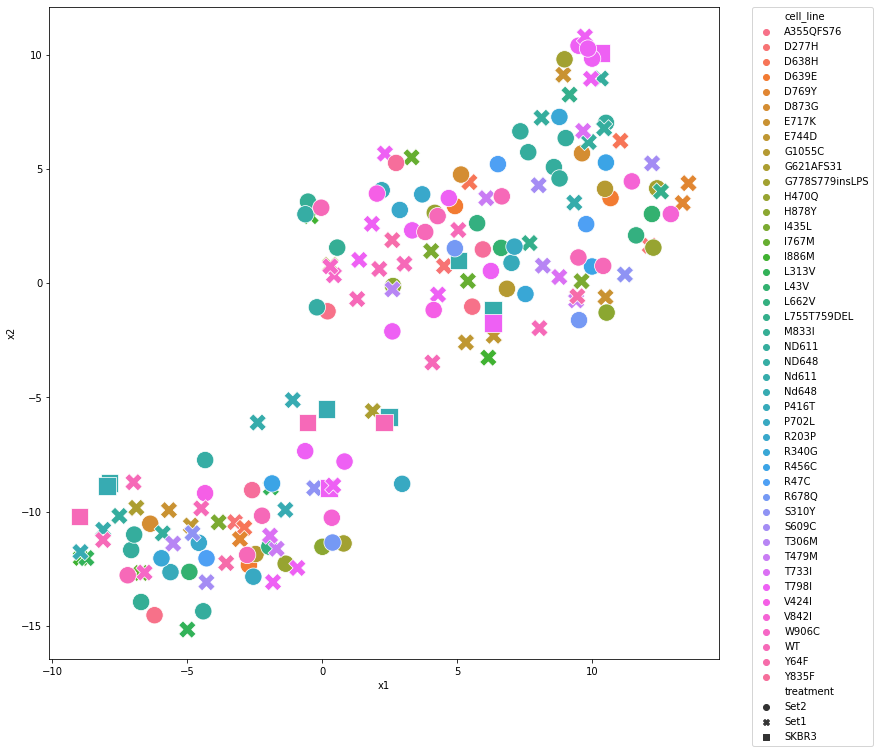

In [252]:
plt.figure(figsize=(12,12))
sbn.scatterplot(x='x1', y='x2', data=res_cm, hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Other stuff

In [269]:
_ = [print(f'{i} : {x}') for i,x in enumerate(lb.classes_)]

0 : skbr3_erk_akt__A355QFS76_10nm_neratinib--H210205_Set2
1 : skbr3_erk_akt__A355QFS76_10ug_ml_trastuzumab--H210205_Set2
2 : skbr3_erk_akt__A355QFS76_untreated--H210205_Set2
3 : skbr3_erk_akt__D277H_10nm_neratinib--H210219_Set1
4 : skbr3_erk_akt__D277H_10ug_ml_trastuzumab--H210219_Set1
5 : skbr3_erk_akt__D277H_untreated--H210219_Set1
6 : skbr3_erk_akt__D638H_10nm_neratinib--H210219_Set1
7 : skbr3_erk_akt__D638H_10ug_ml_trastuzumab--H210219_Set1
8 : skbr3_erk_akt__D638H_untreated--H210219_Set1
9 : skbr3_erk_akt__D639E_10nm_neratinib--H210205_Set2
10 : skbr3_erk_akt__D639E_10ug_ml_trastuzumab--H210205_Set2
11 : skbr3_erk_akt__D639E_untreated--H210205_Set2
12 : skbr3_erk_akt__D769Y_10nm_neratinib--H210212_Set1
13 : skbr3_erk_akt__D769Y_10ug_ml_trastuzumab--H210212_Set1
14 : skbr3_erk_akt__D769Y_untreated--H210212_Set1
15 : skbr3_erk_akt__D873G_10nm_neratinib--H210219_Set2
16 : skbr3_erk_akt__D873G_10ug_ml_trastuzumab--H210219_Set2
17 : skbr3_erk_akt__D873G_untreated--H210219_Set2
18 : skb

In [275]:
# compare distance metrics
#sens_idx = 9 #skbr3_erk_akt__WT_10nm_neratinib
#res_idx = 6 #skbr3_erk_akt__T798I_10nm_neratinib
sens = cm_prob['skbr3_erk_akt__WT_10nm_neratinib--H210122_SKBR3']
res = cm_prob['skbr3_erk_akt__T798I_10nm_neratinib--H210122_SKBR3']

out = {'treatment':[], 'sens_dist':[], 'res_dist':[]}

dist = lambda x,y: np.sum((x-y)**2)**0.5 # euclidean

for i,group in enumerate(labels):
    xx = cm[i, :]
    out['treatment'].append(group)
    out['sens_dist'].append(dist(xx, sens)) 
    out['res_dist'].append(dist(xx, res))
    
out = pd.DataFrame(out)
out = out.assign(drug=[x.split('--')[0].split('_')[-1] for x in out.treatment], 
                 cell_line=[x.split('_')[4] for x in out.treatment])
out.head()


,treatment,sens_dist,res_dist,drug,cell_line
0,skbr3_erk_akt__A355QFS76_10nm_neratinib--H2102...,0.320003,0.272807,neratinib,A355QFS76
1,skbr3_erk_akt__A355QFS76_10ug_ml_trastuzumab--...,0.416666,0.283341,trastuzumab,A355QFS76
2,skbr3_erk_akt__A355QFS76_untreated--H210205_Set2,0.403252,0.214769,untreated,A355QFS76
3,skbr3_erk_akt__D277H_10nm_neratinib--H210219_Set1,0.378562,0.181902,neratinib,D277H
4,skbr3_erk_akt__D277H_10ug_ml_trastuzumab--H210...,0.447033,0.249564,trastuzumab,D277H


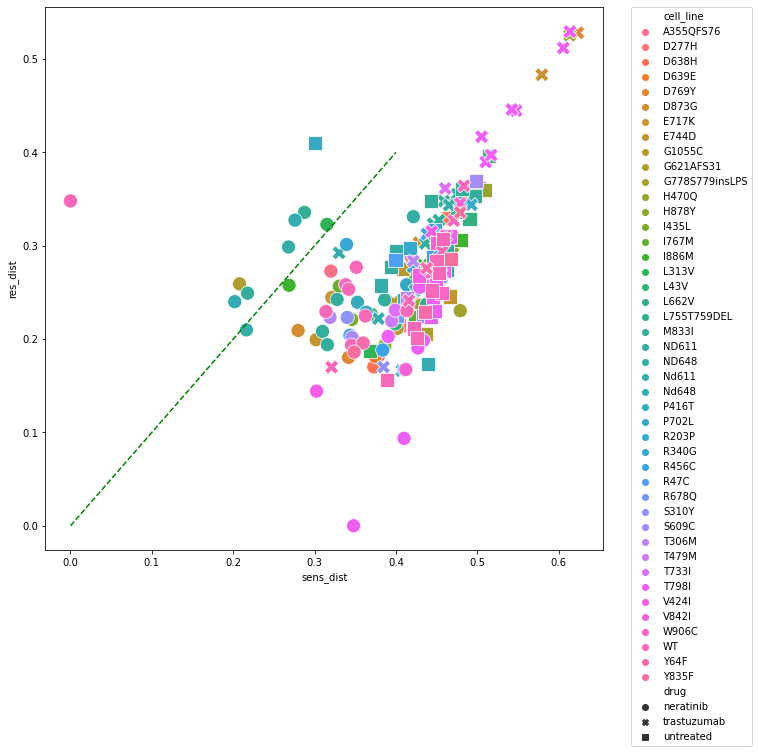

In [276]:
plt.figure(figsize=(10,10))
sbn.scatterplot(x='sens_dist', y='res_dist', data=out, hue='cell_line', style='drug', s=200)
plt.plot((0,0.4), (0,0.4), 'g--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [176]:
# what if its the change that's most important? e.g., unperturbed -> perturbed ? 

drugs = [x for x in np.unique([x.split('_', maxsplit=5)[-1] for x in out.treatment]) if x != 'untreated']
cell_lines = np.unique([x.split('_')[4] for x in out.treatment]) 

out2 = {'cell_line':[], 'drug':[], 'delta_x':[]}
for cl in cell_lines: 
    for drug in drugs: 
        pert_name = 'skbr3_erk_akt__' + cl + '_' + drug
        pert_idx = list(lb.classes_).index(pert_name)
        unpert_name = 'skbr3_erk_akt__' + cl + '_untreated'
        unpert_idx = list(lb.classes_).index(unpert_name)
        
        pert = cm[pert_idx, :]
        unpert = cm[unpert_idx, :]
        delta = pert-unpert
        
        out2['cell_line'].append(cl)
        out2['drug'].append(drug)
        out2['delta_x'].append(delta)
        
out2 = pd.DataFrame(out2)
out2 = out2.assign(eucl_dist = [np.sum(x**2)**0.5 for x in out2.delta_x])
out2.head()

,cell_line,drug,delta_x,eucl_dist
0,A355QFS76,10nm_neratinib,"[0.2498957029620359, -0.02127659574468085, -0....",0.379147
1,A355QFS76,10ug_ml_trastuzumab,"[0.09303295786399667, -0.02127659574468085, -0...",0.190046
2,D277H,10nm_neratinib,"[0.1594267801164353, 0.1724137931034483, -0.22...",0.513754
3,D277H,10ug_ml_trastuzumab,"[0.05101298701298701, 0.008, -0.15677922077922...",0.211320
4,D638H,10nm_neratinib,"[0.16753246753246753, 0.15324675324675324, -0....",0.542882


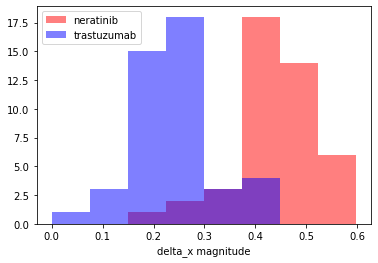

In [177]:
bins = np.linspace(0., max(out2.eucl_dist), 9)
plt.figure()
plt.hist(out2.eucl_dist[out2.drug=='10nm_neratinib'], color='r', bins=bins, label='neratinib', alpha=0.5)
plt.hist(out2.eucl_dist[out2.drug!='10nm_neratinib'], color='b',  bins=bins, label='trastuzumab', alpha=0.5)
plt.legend()
plt.xlabel('delta_x magnitude')
plt.show()

In [178]:
xx = np.stack(out2.delta_x.values, axis=1)

pca = PCA(n_components=2)
PCs = pca.fit_transform(xx)

print('exlplained variance', pca.explained_variance_ratio_)

res2 = pd.DataFrame({'pc1': PCs[:,0], 'pc2':PCs[:,1]}) 
out2 = pd.concat([out2, res2], axis=1)
out2       

exlplained variance [0.53199026 0.12856719]


,cell_line,drug,delta_x,eucl_dist,pc1,pc2
0,A355QFS76,10nm_neratinib,"[0.2498957029620359, -0.02127659574468085, -0....",0.379147,1.185599,0.064146
1,A355QFS76,10ug_ml_trastuzumab,"[0.09303295786399667, -0.02127659574468085, -0...",0.190046,0.710749,-0.178988
2,D277H,10nm_neratinib,"[0.1594267801164353, 0.1724137931034483, -0.22...",0.513754,-1.005893,-0.493272
3,D277H,10ug_ml_trastuzumab,"[0.05101298701298701, 0.008, -0.15677922077922...",0.211320,-0.365418,-0.009745
4,D638H,10nm_neratinib,"[0.16753246753246753, 0.15324675324675324, -0....",0.542882,-0.517353,-0.209915
...,...,...,...,...,...,...
83,WT,10ug_ml_trastuzumab,"[0.07099879230525921, -0.02097650746182822, -0...",0.174710,NaN,NaN
84,Y64F,10nm_neratinib,"[0.22785304846274101, 0.1090411672746222, -0.1...",0.377351,NaN,NaN
85,Y64F,10ug_ml_trastuzumab,"[0.024746499275712222, -0.03029937228392081, -...",0.270282,NaN,NaN
86,Y835F,10nm_neratinib,"[0.16561844863731656, 0.047619047619047616, -0...",0.363959,NaN,NaN


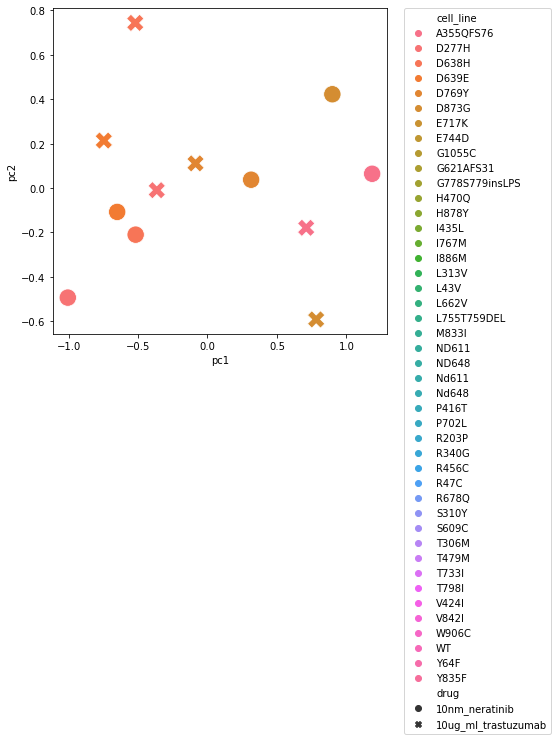

In [180]:
plt.figure(figsize=(6,6))
sbn.scatterplot(x='pc1', y='pc2', data=out2, hue='cell_line', style='drug', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [50]:
out2

,cell_line,drug,delta_x,eucl_dist,pc1,pc2
0,Nd611,10nm_neratinib,"[-0.059335493297757454, 0.16161616161616163, 0...",0.465866,0.053277,0.049709
1,Nd611,10ug_ml_trastuzumab,"[-0.032915576366891616, 0.014598540145985401, ...",0.153219,-0.134689,-0.122550
2,Nd648,10nm_neratinib,"[-0.027013359180749298, 0.11277339963757427, 0...",0.466318,-0.143040,-0.045093
3,Nd648,10ug_ml_trastuzumab,"[0.04981084489281211, -0.007513661202185794, 0...",0.299598,0.099545,-0.082270
4,T798I,10nm_neratinib,"[-0.035247836349331235, 0.06530291109362707, 0...",0.295367,0.223707,0.014299
5,T798I,10ug_ml_trastuzumab,"[0.0010576414595452194, -0.03225806451612903, ...",0.558381,-0.185317,-0.066472
6,WT,10nm_neratinib,"[-0.042003263973888205, -0.0004079967360261088...",0.449879,0.406496,-0.095256
7,WT,10ug_ml_trastuzumab,"[0.041915869218500795, -0.02472089314194577, 0...",0.223879,0.102752,0.169655
8,NaN,NaN,NaN,NaN,-0.280689,-0.078441
9,NaN,NaN,NaN,NaN,-0.337672,-0.117803


In [51]:
res = out2.iloc[4] # T798I	10nm_neratinib
sens= out2.iloc[6] # WT	10nm_neratinib

out3 = {'cell_line':[], 'drug':[], 'res_dist':[], 'sens_dist':[]}
for i,obs in out2.iterrows(): 
    out3['cell_line'].append(obs.cell_line)
    out3['drug'].append(obs.drug)
    out3['res_dist'].append(dist(res.delta_x, obs.delta_x)) 
    out3['sens_dist'].append(dist(sens.delta_x, obs.delta_x))
out3 = pd.DataFrame(out3)
out3 = out3.merge(out2, on=['cell_line', 'drug'])
out3.head()

,cell_line,drug,res_dist,sens_dist,delta_x,eucl_dist,pc1,pc2
0,Nd611,10nm_neratinib,0.227869,0.458392,"[-0.059335493297757454, 0.16161616161616163, 0...",0.465866,0.053277,0.049709
1,Nd611,10ug_ml_trastuzumab,0.279325,0.460817,"[-0.032915576366891616, 0.014598540145985401, ...",0.153219,-0.134689,-0.122550
2,Nd648,10nm_neratinib,0.397690,0.270410,"[-0.027013359180749298, 0.11277339963757427, 0...",0.466318,-0.143040,-0.045093
3,Nd648,10ug_ml_trastuzumab,0.405228,0.418228,"[0.04981084489281211, -0.007513661202185794, 0...",0.299598,0.099545,-0.082270
4,T798I,10nm_neratinib,0.000000,0.443897,"[-0.035247836349331235, 0.06530291109362707, 0...",0.295367,0.223707,0.014299


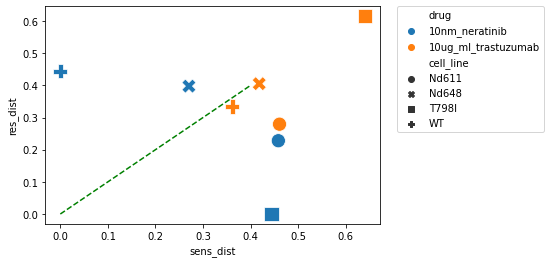

In [52]:
plt.figure()
sbn.scatterplot(x='sens_dist', y='res_dist', data=out3, hue='drug', style='cell_line', s=200)
plt.plot((0,0.4), (0,0.4), 'g--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()